In [1]:
from typing import Union, List, Any, Optional, Dict

import os
import re
import time
import json
import glob
import pickle
import random
import urllib
import requests
import subprocess
import concurrent.futures

import numpy as np
import pandas as pd
import seaborn as sns

from bs4 import BeautifulSoup
from tqdm import tqdm
from pathlib import Path
from textblob import TextBlob
from threading import current_thread
from matplotlib import pyplot as plt
from collections import Counter
from transformers import BertTokenizer, BertModel
from gap_statistic import OptimalK
from sklearn.cluster import KMeans #, AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

try:
    from libKMCUDA import kmeans_cuda
except:
    print("KM cuda not found, defaulting to sklearn CPU version of kmeans")
    kmeans_cuda = None

from utils import cleaning_utils
from utils import cluster_utils
from utils import IDF_computation
from utils import embedding_utils as embedding
from utils.customdocument import CustomDocument

KM cuda not found, defaulting to sklearn CPU version of kmeans


<div class="alert alert-block alert-info"> 
We will run our term extraction on the Merged Approved Documents, the .pdf file can be found in the `data/` directory. For filtering of out-of-domain terms we will also process a set of EU regulations for medical device design, the .html files for these can be found in the same directory.
</div>

1. Preprocessing will consist only of removing headers/footers from PDF files. 

2. Candidate terms are identified using SPaR.txt (Kruiper et al., 2021), sentence splitting is done with the PunkSentTokenizer (Strunk, 2006).

3. Filtering of term candidates consists of:
  * a set of regular expressions found in utils.py
  * clustering of terms found in (1) the Approved Documents, and (2) a set of EU regulations for medical device design; any clusters containing terms from (2) will be designated as terms that are irrelevant to the AEC domain.
  
 


### 1 Preprocessing: get text from PDF and HTML

<div class="alert alert-block alert-info">
Here, we grab the text from our foreground and background corpora.
</div>


In [2]:
input_path = Path("data/input/")
output_dir = Path("data/converted_documents/")
output_dir.mkdir(parents=True, exist_ok=True) # create the converted_documents directory if needed

# NOTE: in our case the foreground corpus is the merged_approved_pdf_file, 
#       and the background corpus is a set of html files
merged_approved_pdf_file = [x for x in input_path.glob("*.pdf")][0]
eu_html_files = [x for x in input_path.glob("*.html")]

print(f"Approved Documents: {merged_approved_pdf_file}")
print(f"Reference corpus: {[str(x) for x in eu_html_files]}")

Approved Documents: data/input/The Merged Approved Documents.pdf
Reference corpus: ['data/input/EUR-Lex - 31993L0042 - EN.html', 'data/input/CELEX 32017R0746 EN TXT.html', 'data/input/CELEX 32017R0745 EN TXT.html', 'data/input/EUR-Lex - 31998L0079 - EN.html', 'data/input/EUR-Lex - 31990L0385 - EN.html']


In [3]:
merged_approved_pdf_file.exists()

True

<div class="alert alert-block alert-info">
First we grab the text from the Merged Approved Documents pdf file. Our implementation on based on the pdf conversion pipeline in Haystack.
</div>

In [4]:
def read_pdf(file_path: Path, layout: bool = True, encoding: Optional[str] = "Latin1") -> List[str]:
        """
        Extract pages from the pdf file at file_path; based on Haystack.

        :param file_path: path of the pdf file
        :param layout: whether to retain the original physical layout for a page. If disabled, PDF pages are read in
                       the content stream order.
        """
        if layout:
            command = ["pdftotext", "-enc", encoding, "-layout", str(file_path), "-"]
        else:
            command = ["pdftotext", "-enc", encoding, str(file_path), "-"]
        output = subprocess.run(command, stdout=subprocess.PIPE, shell=False)  # type: ignore
        document = output.stdout.decode(errors="ignore")
        pages = document.split("\f")
        pages = pages[:-1]  # the last page in the split is always empty.
        return pages

def convert_pdf_to_mydoc(source_file_path: Path, 
                         output_file_path: Path, 
                         meta: Optional[Dict[str, str]] = None,
                         remove_header_and_footer: Optional[bool] = True,
                         clean_whitespace: Optional[bool] = True,
                         clean_empty_lines: Optional[bool] = True,
                         encoding: Optional[str] = "Latin1") -> CustomDocument:
        """
        Extract pages from the pdf file at file_path; based on Haystack.

        :param output_file_path:    Path to the .json file to store the converted file.
        :param source_file_path:    Path to the .pdf file you want to convert
        :param meta: Optional dictionary with metadata that shall be attached to all resulting documents.
                     Can be any custom keys and values.
        :param encoding: Encoding that will be passed as -enc parameter to pdftotext. "Latin 1" is the default encoding
                         of pdftotext. While this works well on many PDFs, it might be needed to switch to "UTF-8" or
                         others if your doc contains special characters (e.g. German Umlauts, Cyrillic characters ...).
                         Note: With "UTF-8" we experienced cases, where a simple "fi" gets wrongly parsed as
                         "xef\xac\x81c" (see test cases). That's why we keep "Latin 1" as default here.
                         (See list of available encodings by running `pdftotext -listenc` in the terminal)
        """
        pages = read_pdf(source_file_path, layout=True, encoding=encoding)

        if not pages:
            # empty input file
            return None
        
        pages = ["\n".join(p.splitlines()) for p in pages]

        # splitting text happens during preprocessing, so no split_size passed here;
        # split_size will be set to -1 during conversion.
        document = CustomDocument(output_file_path, source_file_path, split_size=-1)
        
        print("Converted PDF file to pages of text, combining to a single CustomDocument to keep track of page nrs.")
        for page_idx, page in tqdm(enumerate(pages)):
            
            # some simple cleaning -- roughly based on haystack.
            lines = page.splitlines()
            if remove_header_and_footer:
                # simplest way for removing header and footer 
                lines = lines[1:-2]

            if clean_whitespace:
                cleaned_lines = []
                for line in lines:
                    line = line.strip()
                    cleaned_lines.append(line)
                text = " ".join(cleaned_lines)

            if clean_empty_lines:
                text = re.sub(r"\n\n+", "\n\n", text)
                text = re.sub(r"[\s]+", " ", text)
            
            # no splitting here yet, so simply using page_nr as a place holder and split_id is left blank
            page_nr = str(page_idx + 1)
            document.add_content(text=text, 
                                 page_nr=page_nr, 
                                 doc_title=source_file_path.name)   # we're using the pdf file name for simplicity

        return document

In [5]:
output_path = output_dir.joinpath("merged_approved.json")
merged_approved_document = convert_pdf_to_mydoc(merged_approved_pdf_file, output_path)

Converted PDF file to pages of text, combining to a single CustomDocument to keep track of page nrs.


1274it [00:00, 4526.38it/s]


In [6]:
print(f"Maximum character length for a single block of text: {max([len(c.text) for c in merged_approved_document.all_contents])}")

Maximum character length for a single block of text: 5537


In [7]:
sorted(merged_approved_pdf_file.parent.glob("*"))

[PosixPath('data/input/CELEX 32017R0745 EN TXT.html'),
 PosixPath('data/input/CELEX 32017R0746 EN TXT.html'),
 PosixPath('data/input/EUR-Lex - 31990L0385 - EN.html'),
 PosixPath('data/input/EUR-Lex - 31993L0042 - EN.html'),
 PosixPath('data/input/EUR-Lex - 31998L0079 - EN.html'),
 PosixPath('data/input/The Merged Approved Documents.pdf'),
 PosixPath('data/input/uniclass_2015.ttl'),
 PosixPath('data/input/uniclass_2015.ttl.json')]

<div class="alert alert-block alert-info">
Second, we grab the text from the EU regulation HTML files. Because the text in HTML files isn't split into pages, the blocks of text are much longer.
</div>

In [8]:
def grab_HTML_text_simple(file_path: Path):
    """
    All text in the EU htmls seems to be captured neatly in <p> tags, we don't care about structure currently.
    We do remove all unicode characters, see `utils.remove_unicode_chars()`.
    """ 
    with open(file_path, 'r') as f:
        text = f.read()
    soup = BeautifulSoup(text, 'html.parser')
    return [cleaning_utils.remove_unicode_chars(x.text) for x in soup.body.find_all('p')]

In [9]:
def convert_html_to_mydoc(source_file_path: Path, 
                          output_file_path: Path) -> CustomDocument:
    
    document = CustomDocument(output_file_path, source_file_path, split_size=-1)
    document_paragraphs = []
    list_of_paragraphs = grab_HTML_text_simple(source_file_path)
    for paragraph in list_of_paragraphs:
        if paragraph.strip() != '':
            document_paragraphs.append(paragraph)
    
    for paragraph_idx, paragraph in tqdm(enumerate(document_paragraphs)):
            # no splitting here yet, so simply using page_nr as a place holder and split_id is left blank
            paragraph_nr = str(paragraph_idx + 1)
            document.add_content(text=paragraph, 
                                 page_nr=paragraph_nr, 
                                 doc_title=source_file_path.name) # we're using the html file name for simplicity
    return document

In [10]:
eu_regulation_documents = []

for html_file in tqdm(eu_html_files):
    output_path = output_dir.joinpath(html_file.stem + ".json")
    eu_regulation_documents.append(convert_html_to_mydoc(html_file, output_path))


  0%|                                                                                                                                                                               | 0/5 [00:00<?, ?it/s]
826it [00:00, 195281.84it/s]

4344it [00:00, 205003.06it/s]
 40%|██████████████████████████████████████████████████████████████████▊                                                                                                    | 2/5 [00:01<00:02,  1.47it/s]
4799it [00:00, 201926.78it/s]
 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 3/5 [00:02<00:01,  1.06it/s]
623it [00:00, 154600.13it/s]

511it [00:00, 142505.94it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.81it/s]


In [11]:
print(f"Maximum character length for a single paragraph: {max([len(c.text) for d in eu_regulation_documents for c in d.all_contents])}")

Maximum character length for a single paragraph: 143428


<div class="alert alert-block alert-info">
Third, if the output document doesn't exist (yet), we save the ConvertedDocument.
</div>

In [12]:
foreground_corpus = [merged_approved_document]
background_corpus = eu_regulation_documents

In [13]:
for d in foreground_corpus + background_corpus:
    if not os.path.exists(d.output_fp):
        d.write_document()

### 2 Term extraction: identify object spans with SPaR.txt

<div class="alert alert-block alert-info">
For each of the sentences in our corpora, we run SPaR.txt for object identification.
</div>


Note; on a mac, you may have to install the Xcode commandline developer tools. Open a terminal window and run `xcode-select --install` or download Xcode through the App store.



In [14]:
# download SPaR.txt if required

spartxt_path = Path("SPaR.txt/")
if not spartxt_path.exists():
    !git clone https://github.com/rubenkruiper/SPaR.txt.git

In [15]:
import imp
with open(spartxt_path.joinpath('spar_predictor.py'), 'rb') as fp:
    spar_predictor = imp.load_module(
        'spar_predictor', fp, 'SPaR.txt.spar_predictor.py',
        ('.py', 'rb', imp.PY_SOURCE)
    )

In [16]:
# trains a model if needed, otherwise loads from archive; 
# - best F1 on dev/validation in the paper is 80,96 trained on a GPU, CPU will be a bit lower ~77.x I think
sp = spar_predictor.SparPredictor()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [17]:
# example 
example = "An example sentence to show how ACC terminology will be extracted from the British Standards."
start_time = time.time()
# prepare instance and run model on single instance
docid = ''                  # ToDo - add doc_id during pre_processing?
token_list = sp.predictor._dataset_reader.tokenizer.tokenize(example)
instance = sp.predictor._dataset_reader.text_to_instance(docid,
                                                      example,
                                                      token_list,
                                                      sp.predictor._dataset_reader._token_indexer)
result = sp.predictor.predict_instance(instance)
printable_result = sp.parse_output(result, ['obj'])
print(f"Example input: {example}")
print(printable_result)
print("Parsing took {}".format(time.time() - start_time))

Example input: An example sentence to show how ACC terminology will be extracted from the British Standards.
{'obj': ['An example sentence', 'ACC terminology', 'the British Standards']}
Parsing took 0.15544700622558594


* To run SPaR.txt, we split the text in our corpora into sentences. We set up multiple instances of SPaR.txt predictors to speed up the processing a little.

In [18]:
# These should automatically run on your Nvidia GPU if available
class SparInstance:
    def __init__(self):
        self.sp = spar_predictor.SparPredictor()
    
    def call(self, input_str:str=''):
        if input_str:
            # prepare instance and run model on single instance
            docid = ''  # ToDo - add doc_id during pre_processing?
            token_list = self.sp.predictor._dataset_reader.tokenizer.tokenize(input_str)

            # truncating the input to SPaR.txt to maximum 512 tokens
            token_length = len(token_list)
            if token_length > 512:
                token_list = token_list[:511] + [token_list[-1]]
                token_length = 512

            instance = self.sp.predictor._dataset_reader.text_to_instance(docid, input_str, token_list,
                                                              self.sp.predictor._dataset_reader._token_indexer)
            result = self.sp.predictor.predict_instance(instance)
            printable_result = self.sp.parse_output(result, ['obj'])
            return {
                    "prediction": printable_result,
                    "num_input_tokens": token_length,
            }
            
        # If the input is None, or too long, return an empty list of objects
        return {
                "prediction": {'obj': []},
                "num_input_tokens": 0
            }


In [19]:
class TermExtractor:
    
    def __init__(self, split_length=300, max_num_cpu_threads=4):
        """
        Initialise SPaR.txt predictors `max_num_cpu_threads` 
        """
        self.split_length = split_length   # in number of tokens
        self.max_num_cpu_threads = max_num_cpu_threads
        self.PREDICTORS = []
        for i in range(max_num_cpu_threads + 1):
            self.PREDICTORS.append(SparInstance())
    
    
    def process_sentence(self, sentence: str = ''):
        """
        """
        predictor_to_use = int(current_thread().name.rsplit('_', 1)[1])
        spartxt = self.PREDICTORS[predictor_to_use]

        # SPaR doesn't handle ALL uppercase sentences well, which the OCR system sometimes outputs    
        sentence = sentence.lower() if sentence.isupper() else sentence
        prediction_dict =  spartxt.call(sentence)
        if not prediction_dict:
            return []

        pred_labels = prediction_dict["prediction"]
        return pred_labels['obj']
        

    def split_into_sentences_and_run_spar(self, input_document: CustomDocument):
        """
        """
        print(f"Working on: {input_document.source_fp}")
        content_as_list_of_dicts = input_document.to_list_of_dicts()
        total_number_of_sentences_found = 0
        content_idx = 0
        for content_dict in tqdm(content_as_list_of_dicts):

            text = ' '.join([x for x in content_dict["content"].split(' ') if x != ''])
            # some really long paragraphs in the EU regulations are summations that should be split at ';'
            if len(text) > 3000:
                text = text.replace(";", ".\n")

            # We'll split into sentences even if this has been done before, it doesn't take long
            sentences = []
            for part in text.split('\n'):
                # split into sentences using PunktSentTokenizer (TextBlob implements NLTK's version under the hood) 
                sentences += [str(s) for s in TextBlob(part).sentences if len(str(s)) > 10]

            content_dict["meta"]["sentences"] = '###'.join(sentences)
                
            total_number_of_sentences_found += len(sentences)

            # process sentences in the content and add SPaR.txt object tags to the content dict.        
            if not content_dict["meta"]["SPaR_labels"]:
                with concurrent.futures.ThreadPoolExecutor(max_workers=self.max_num_cpu_threads) as executor:
                    futures = [executor.submit(self.process_sentence, sentences[idx]) for idx in range(len(sentences))]

                content_spar_objects = [f.result() for f in futures]
                content_dict["meta"]["SPaR_labels"] = ', '.join([tag for tags in content_spar_objects for tag in tags])
                
            # immediately update the list of content_dicts and every X iterations we save the file 
            content_as_list_of_dicts[content_idx] = content_dict
            if content_idx // 5 == 0:
                converted_document.replace_contents(content_as_list_of_dicts)
                converted_document.write_document()
            
            content_idx += 1

        print(f"Number of sentences found: {total_number_of_sentences_found}")
        converted_document.replace_contents(content_as_list_of_dicts)
        converted_document.write_document()
        

In [20]:
te = TermExtractor()

In [21]:
# Run SPaR.txt on all documents and write to file
for converted_document in foreground_corpus + background_corpus:
    # re-load the document from file, to make sure we don't overwrite existing SPaR.txt labels
    converted_document = converted_document.load_document(converted_document.output_fp)
    te.split_into_sentences_and_run_spar(converted_document)
    

Working on: data/input/The Merged Approved Documents.pdf


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1274/1274 [00:01<00:00, 657.49it/s]


Number of sentences found: 17745
Working on: data/input/EUR-Lex - 31993L0042 - EN.html


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 826/826 [00:00<00:00, 3325.10it/s]


Number of sentences found: 1679
Working on: data/input/CELEX 32017R0746 EN TXT.html


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4344/4344 [00:02<00:00, 1925.68it/s]


Number of sentences found: 3405
Working on: data/input/CELEX 32017R0745 EN TXT.html


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4799/4799 [00:01<00:00, 2806.50it/s]


Number of sentences found: 3838
Working on: data/input/EUR-Lex - 31998L0079 - EN.html


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 623/623 [00:00<00:00, 2384.30it/s]


Number of sentences found: 1255
Working on: data/input/EUR-Lex - 31990L0385 - EN.html


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 511/511 [00:00<00:00, 3907.06it/s]

Number of sentences found: 771


<div class="alert alert-block alert-info">
Number of sentences (longer than 10 characters) found in: <ul>
    <li>Merged Approved documents: 17745</li>
    <li>Background corpus (1679+3405+3838+1255+771): 10948</li>
    </ul>
</div>

### 3 Filtering
<div class="alert alert-block alert-info">
The objects identified by SPaR.txt contain a lot of noise. Here, we clean and filter them; based on our background corpus we try to identify which terms belong to the AEC domain. 
</div>

<div class="alert alert-block alert-info">
First, load all terms from the processed files.
</div>

In [22]:
foreground_terms_lists = [c.NER_labels for d in foreground_corpus for c in d.load_document(d.output_fp).all_contents]
foreground_terms = [t for t_list in foreground_terms_lists for t in t_list if t]
foreground_terms_c = Counter(foreground_terms)
print(f"Total number of foreground terms: {len(foreground_terms)}")
print(f"Total number of UNIQUE foreground terms: {len(foreground_terms_c)}")
foreground_terms_c.most_common(10)

Total number of foreground terms: 114333
Total number of UNIQUE foreground terms: 42657


[('the', 2130),
 ('a', 930),
 ('the building', 864),
 ('buildings', 839),
 ('guidance', 522),
 ('a building', 455),
 ('the Building Regulations', 434),
 ('document', 303),
 ('people', 301),
 ('the requirements', 297)]

In [23]:
background_terms_lists = [c.NER_labels for d in background_corpus for c in d.load_document(d.output_fp).all_contents]
background_terms = [t for t_list in background_terms_lists for t in t_list if t]
background_terms_c = Counter(background_terms)
print(f"Total number of background terms: {len(background_terms)}")
print(f"Total number of UNIQUE background terms: {len(background_terms_c)}")
background_terms_c.most_common(10)

Total number of background terms: 73124
Total number of UNIQUE background terms: 10245


[('the', 2651),
 ('devices', 1641),
 ('the manufacturer', 1243),
 ('the device', 1187),
 ('Regulation', 624),
 ('the notified body', 595),
 ('information', 550),
 ('Member States', 489),
 ('a', 451),
 ('the market', 447)]

In [24]:
print(f"Total number of unique spans identified by SPaR.txt:{len(foreground_terms_c+background_terms_c)}")

Total number of unique spans identified by SPaR.txt:51296


<div class="alert alert-block alert-info">
Second, clean the terms with the regular expressions we've defined in utils.py
</div>

In [25]:
regex_filter = cleaning_utils.RegexFilter()
def run_filters(input_counter):
    cleaned_counter = Counter()
    for k, v in input_counter.items():
        # terms should occur twice at least
        if v < 2:
            continue

        # todo; clean up these util functions and how to call them|
        _, k = regex_filter.run_filter(k)
        if k:
            cleaned_k = cleaning_utils.custom_cleaning_rules(k)
            if cleaned_k:
                cleaned_counter[cleaned_k[0]] = v
    return cleaned_counter

In [26]:
cleaned_foreground_terms_c = run_filters(foreground_terms_c)
print(len(cleaned_foreground_terms_c))
cleaned_foreground_terms_c.most_common(10)

11187


[('guidance', 522),
 ('a building', 455),
 ('document', 303),
 ('the requirements', 297),
 ('requirements', 266),
 ('work', 242),
 ('the guidance', 240),
 ('the work', 232),
 ('Schedule 1', 226),
 ('the dwelling', 215)]

In [27]:
cleaned_background_terms_c = run_filters(background_terms_c)
print(len(cleaned_background_terms_c))
cleaned_background_terms_c.most_common(10)

6189


[('devices', 1641),
 ('the device', 1187),
 ('the notified body', 595),
 ('Member States', 489),
 ('accordance', 429),
 ('a device', 405),
 ('conformity', 357),
 ('the requirements', 350),
 ('The notified body', 328),
 ('notified bodies', 324)]

<div class="alert alert-block alert-info">
Third, we compute the embeddings for both foreground and background terms.
</div>


* Note: **embeddings** will be IDF weighted (IDF weights over both foreground and background corpora)
  * Could add more sentences to the computation of IDF weights, e.g., definitions from vocabularies/WikiData.

In [28]:
# Which tokenizer to use for IDF computation and Embedding;
bert_model_name = 'bert-base-cased'
embedding_output_fp = Path("output/")

In [29]:
# store the cleaned backgrount_terms
with open(Path(embedding_output_fp.joinpath("unique_background_spans.pkl")), 'wb') as f:
    pickle.dump([span for span in cleaned_background_terms_c.keys()], f)

In [30]:
all_terms_c = cleaned_foreground_terms_c + cleaned_background_terms_c

In [31]:
len(all_terms_c)

16441

In [32]:
all_terms_c.most_common(10)

[('devices', 1665),
 ('the device', 1195),
 ('the requirements', 647),
 ('accordance', 631),
 ('the notified body', 595),
 ('guidance', 539),
 ('Member States', 491),
 ('requirements', 457),
 ('a building', 455),
 ('a device', 412)]

In [33]:
# some insight in number of MWEs
mwes = []
for t in all_terms_c.keys():
    words = t.split(' ')
    if words[0] in ['the', 'a', 'The', 'A', 'an', 'An', 'any', 'Any', 'this', 'This']:
        words = words[1:]
    if len(words) > 1:
        mwes.append(t)

print(f"Number of MWEs: {len(mwes)}")
random.sample(mwes, 100)


Number of MWEs: 10833


['Application form',
 'the enclosures fanlights Unlim',
 'sub - division',
 'Compartment wall',
 'a minimal burden',
 'Diagram 18',
 'nt number',
 'the clinical conditions safety',
 'thick classification',
 'above ground drainage',
 'the Door and Hardware Federation',
 'linear bar codes',
 'Background ventilators',
 'the air vent equivalent area',
 'number bedrooms',
 'a downward -',
 'the biological functionality',
 'ground D4 Height of',
 'classification rules',
 'Section 13',
 'AIDC packaging',
 'blood transfusion',
 'the inside out',
 'Member State s',
 'a cubic capacity',
 'Diagram 1 2',
 'diagnostic examinations',
 'foul air',
 'the exposed perimeter floor area',
 'a door chain',
 'Fire Performance',
 'ground floor slabs',
 'compartment floors',
 'timber raft',
 'two years',
 'the historic building',
 'ground gases',
 'a BROOF t4 )',
 'kilograms per cubic metre',
 'structural purposes',
 'a systematic follow - up',
 'class C D devices',
 'Model Procedures',
 'the building design'

In [34]:
# Compute IDF weights
sentence_lists = [c.sentences for d in foreground_corpus + background_corpus for c in d.load_document(d.output_fp).all_contents]
all_sentences = [s for sent_list in sentence_lists for s in sent_list if s]

In [35]:
print(len(all_sentences))
all_sentences[:10]

28693


['The Merged Approved Documents',
 'How to use the Merged Approved Documents This document combines the approved documents into a single PDF.',
 'Each approved document is self-contained and has its own introduction.',
 'Each introduction relates only to the corresponding approved document.',
 "Each introduction also contains information on when the document's guidance came into effect (or will come into effect).",
 'It is important to check that the version of each approved document you are using remains current and is the correct version for your project.',
 'Please refer to the Ministry of Housing, Communities and Local Government website to check, and confirm with your building control body if in doubt.',
 'Key features The Merged Approved Documents enable the user to: undertake a word search across all of the approved documents cut and paste text and diagrams into other documents add notes to a saved copy use an index to access individual sections of the guidance Correction to App

In [36]:
IDF_path = Path("data/IDF_weights.json")
IDF_c = IDF_computation.IdfComputer(IDF_path, bert_model_name=bert_model_name)
IDF_path = IDF_c.compute_or_load_IDF_weights(all_sentences, overwrite=False)

Loading existing IDF weights.
Printing some IDF values, should be subword units!
['cluster']
['##of']
['deposits']
['ultimate']
['horizontal']
['proximity']
['estates']
['exploration']
['##most']
['rendered']


#### Embed each of the terms identified by SPaR.txt
* TF-IDF weighting and threshold

In [37]:
all_terms = [k for k in all_terms_c.keys()] # counter keys, so already unique
print(f"Number of unique terms: {len(all_terms)}")
all_terms[:10]

Number of unique terms: 16441


['the Merged Approved Documents',
 'document',
 'documents',
 'Each introduction',
 'approved',
 'information',
 'guidance',
 'the version',
 'project',
 'the Ministry']

In [38]:
tokenizer = BertTokenizer.from_pretrained(bert_model_name)
bert_model = BertModel.from_pretrained(bert_model_name, output_hidden_states=True)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [39]:
embedder = embedding.Embedder(tokenizer, bert_model, 
                              IDF_dict=json.load(open(IDF_path)), 
                              embedding_fp=embedding_output_fp,
                              layers_to_use = [12],         # we'll use the output of the last layer
                              layer_combination = "avg",    # how to combine layers if multiple are used
                              idf_threshold = 1.5,          # minimum IDF value for a token to contribute
                              idf_weight_factor = 1.0,      # modify how strong the influence of IDF weighting is
                              not_found_idf_value = 0.5)    # IDF value for tokens that weren't seen during IDF computation (doesn't apply here)

In [40]:
# Compute the embeddings, this is split into subsets so we don't overload your memory (adjust these values if needed)
max_num_cpu_threads = 4
subset_size = 1000

# Checks which of the embeddings for the clustering cluster_data already exist, so they can be re-used
term_subsets = cleaning_utils.split_list(all_terms, subset_size)
embedding_files = [f for f in embedder.embedding_fp.glob('embeddings*.pkl')]
span_and_embedding_pairs = []
if len(embedding_files) == len(term_subsets):
    for e in embedding_files:
        span_and_embedding_pairs += pickle.load(open(e, 'rb'))
else:
    print(f"Preparing embeddings for {len(all_terms)} spans, in groups of: {subset_size}")
    subset_idx = 0            # iterator index outside of tqdm 
    for subset in tqdm(term_subsets):
        subset_embeddings = []
        subset_file_name = embedder.embedding_fp.joinpath("embeddings_part_", "{}.pkl".format(subset_idx))
        subset_idx += 1
        if subset_file_name.exists():
            # already computed previously
            continue
        
        with concurrent.futures.ThreadPoolExecutor(max_workers=max_num_cpu_threads) as executor:
            futures = [executor.submit(embedder.embed_a_span, subset[idx]) for idx in range(len(subset))]

        subset_embeddings += [f.result() for f in futures if f.result()]

        with open(subset_file_name, 'wb') as f:
            pickle.dump(subset_embeddings, f)

    # Once all embeddings are created; combine them in span_and_embedding_pairs
    embedding_files = [f for f in embedder.embedding_fp.glob('embeddings*.pkl')]
    for e in embedding_files:
        span_and_embedding_pairs += pickle.load(open(e, 'rb'))

In [41]:
# Create a single file with all embeddings, in the meantime standardising the embeddings to improve the representation
print(f"Normalising and combining computed/existing {len(embedding_files)} embeddings from files into single file")
unique_spans, unique_embeddings = zip(*span_and_embedding_pairs)
with open(embedder.embedding_fp.joinpath("unique_spans.pkl"), 'wb') as f:
    pickle.dump(unique_spans, f)

with open(embedder.embedding_fp.joinpath("unique_embeddings.pkl"), 'wb') as f:
    # we average over the token embeddings in a term
    unique_clustering_data = np.stack([np.mean(e, axis=0) if len(e.shape) > 1 else e for e in unique_embeddings])

    # standardise the unique clustering data, as suggested by https://github.com/wtimkey/rogue-dimensions
    embedder.emb_mean = unique_clustering_data.mean(axis=0)
    embedder.emb_std = unique_clustering_data.std(axis=0)
    pickle.dump(embedder.emb_mean, open(embedder.embedding_fp.joinpath("standardisation_mean.pkl"), 'wb'))
    pickle.dump(embedder.emb_std, open(embedder.embedding_fp.joinpath("standardisation_std.pkl"), 'wb'))

    standardised_clustering_data = (unique_clustering_data - embedder.emb_mean) / embedder.emb_std

    pickle.dump(standardised_clustering_data, f)
    
# Store the standardised embeddings for reuse; could honeslty remove all the other embedding files but will keep them just in case
pickle.dump(standardised_clustering_data, open(embedder.embedding_fp.joinpath("standardised_embeddings.pkl"), 'wb'))
spans_and_standardised_embeddings_dict = dict(zip(unique_spans, standardised_clustering_data))
# pickle.dump(spans_and_standardised_embeddings_dict, open(embedder.embedding_fp + "spans_and_standardised_embeddings_dict.pkl", 'wb'))

Normalising and combining computed/existing 17 embeddings from files into single file


<div class="alert alert-block alert-info">
Fourth, we determine which terms may be domain-specific. We compare on (1) the number of nearest neighbours of a term that occur in the background corpus, (2) the frequency of terms in each corpus including a simplified version of KL divergence, and (3) a foreground/background TF-IDF for each span.
</div>

In [42]:
# 1 check the kNNs based on the standardised embeddings
n_neighbors = 500 # the number of neighbours we compute for each term
knn_graph = kneighbors_graph(standardised_clustering_data, 
                             n_neighbors,    
                             metric="cosine", 
                             n_jobs=8)

In [43]:
span_df_dict = {}
for span_idx, span in enumerate(unique_spans):
    number_of_background_corpus_neighbours = 0
    for neighbour_idx in knn_graph[span_idx].indices:
        if unique_spans[neighbour_idx] in cleaned_background_terms_c.keys():
            number_of_background_corpus_neighbours += 1
    
    span_df_dict[span] = {'span_idx': span_idx, 
                          'num_background_neighbours': number_of_background_corpus_neighbours,
                          'num_foreground_neighbours': n_neighbors - number_of_background_corpus_neighbours}

In [44]:
# 2 Grab a KL divergence type of notion for each span
total_foreground = sum(cleaned_foreground_terms_c.values())
total_background = sum(cleaned_background_terms_c.values())
    

for span in unique_spans:
    foreground_cnt = cleaned_foreground_terms_c[span]
    background_cnt = cleaned_background_terms_c[span]
    
    span_df_dict[span]['foreground_cnt'] = foreground_cnt
    span_df_dict[span]['background_cnt'] = background_cnt
#     TF_fore_back = foreground_cnt/(foreground_cnt+background_cnt)
    TF_fore_back = np.log(1+ (foreground_cnt/(foreground_cnt+background_cnt)))
    
    tokens, indices = embedder.prepare_tokens(span)
    idf_weights = embedder.get_IDF_weights_for_indices(tokens, indices)
    TFIDF_fore_back = TF_fore_back * np.log(np.mean(idf_weights))
    
    span_df_dict[span]['TFIDF_fore_back'] = TFIDF_fore_back
    
    # DEPRECATED; simplified version of KL divergence based on Meyers et al. 2018, add + 1 above to avoid NAN and INF results
    # The KLD feature has extreme outliers that occur VERY often in the foreground corpus, and a few times in the background corpus
    # an  example is "guidance" (400+/17), which clearly is a general domain term. So the KLD doesn't necessarily provide the information we want
#     KLD = (np.log(foreground_cnt + 1) - np.log(background_cnt + 1))* (foreground_cnt + 1)
#     span_df_dict[span]['KLD'] = KLD
    
    

In [45]:
# example of a clear AEC domain term
span_df_dict['mortar']

{'span_idx': 8849,
 'num_background_neighbours': 233,
 'num_foreground_neighbours': 267,
 'foreground_cnt': 13,
 'background_cnt': 0,
 'TFIDF_fore_back': 0.8100886563679047}

In [46]:
# example of a clear medical domain term
span_df_dict['patients']

{'span_idx': 2213,
 'num_background_neighbours': 315,
 'num_foreground_neighbours': 185,
 'foreground_cnt': 0,
 'background_cnt': 118,
 'TFIDF_fore_back': 0.0}

In [47]:
# example of a clear general domain term
span_df_dict['test']

{'span_idx': 8092,
 'num_background_neighbours': 332,
 'num_foreground_neighbours': 168,
 'foreground_cnt': 2,
 'background_cnt': 4,
 'TFIDF_fore_back': 0.25761421149722813}

In [48]:
# example of a long AEC domain term
span_df_dict['hot water storage system']

{'span_idx': 14292,
 'num_background_neighbours': 45,
 'num_foreground_neighbours': 455,
 'foreground_cnt': 6,
 'background_cnt': 0,
 'TFIDF_fore_back': 0.9105500612603409}

In [49]:
span_features_df = pd.DataFrame.from_dict(span_df_dict, orient='index')
span_features_df

,span_idx,num_background_neighbours,num_foreground_neighbours,foreground_cnt,background_cnt,TFIDF_fore_back
vessel,0,236,264,3,0,0.829818
expansion water,1,47,453,2,0,0.942027
a hot water system,2,48,452,2,0,0.797904
PLY,3,95,405,2,0,0.965562
the outlet,4,234,266,8,0,0.642198
...,...,...,...,...,...,...
the establishments,16436,300,200,0,2,0.000000
a database,16437,280,220,0,2,0.000000
the vigilance procedure,16438,313,187,0,8,0.000000
a system of,16439,280,220,0,2,0.000000


In [50]:
print("most FORE-groundy terms according to TF_fore_back:")
span_features_df['TFIDF_fore_back'].nlargest(10)

most FORE-groundy terms according to TF_fore_back:


Second Edition Safety of Sports Grounds Act 1975 ASFP Blue Book British Standard version Fire Regulatory Reform    1.314421
photovoltaic array                                                                                                 1.309056
HMPPSFireSafetyDesignGuide pdf                                                                                     1.304546
Architectural Ironmongers                                                                                          1.301754
Market Transformation Programme                                                                                    1.299072
sleeping Nil Nil Nil Nil accommodation                                                                             1.296336
ribabookshops com                                                                                                  1.294767
Polyethylene                                                                                                       1.292763
Educatio

In [51]:
print("most BACK-groundy terms according to TF_fore_back:")
span_features_df['TFIDF_fore_back'].nsmallest(10)

most BACK-groundy terms according to TF_fore_back:


Avis juridique                                     0.0
Council Directive 93 / 42 / EEC of 14 June 1993    0.0
medical devices                                    0.0
COUNCIL DIRECTIVE 93 / 42 / EEC of 14 June 1993    0.0
THE EUROPEAN COMMUNITIES                           0.0
the Treaty                                         0.0
the European Economic Community                    0.0
Article 100a                                       0.0
the proposal 1 )                                   0.0
cooperation                                        0.0
Name: TFIDF_fore_back, dtype: float64

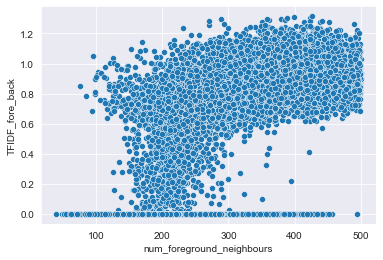

In [52]:
sns.set_style ("darkgrid")
sns.scatterplot(x="num_foreground_neighbours",
                y="TFIDF_fore_back",
                data=span_features_df)

# we'll also save span_features_df for reuse elsewhere
span_features_df.to_csv(embedding_output_fp.joinpath("span_features.csv"))

There seems to be some weak correlation between:
1. the number of foreground neighbours
2. the TF-IDF inspired value for a span, a value of 0 indicating that the term only appears in the background corpus

Our assumption is that at certain values this correlation indicates how 'domain-specific' a term is.
We should do some more tests to validate this.
For now, we'll assume that general background domain terms have:
* a low TF-IDF value, e.g., smaller than 0.5
* a relatively small number of foreground terms, e.g., cut-off at 200/500

In [53]:
min_TFIDF_value = 0.5
min_num_foreground_neighbours = 200

domain_terms = span_features_df[(span_features_df['TFIDF_fore_back'] >= min_TFIDF_value) & (span_features_df['num_foreground_neighbours'] >= min_num_foreground_neighbours)]
ood_terms = span_features_df[(span_features_df['TFIDF_fore_back'] < min_TFIDF_value) | (span_features_df['num_foreground_neighbours'] < min_num_foreground_neighbours)]


In [54]:
print(f"Examples of our {len(domain_terms)} AEC domain terms")
random.sample(domain_terms.index.tolist(), 10)

Examples of our 10026 AEC domain terms


['sockets',
 'the WC facility',
 'Walls',
 'Parts A P )',
 'kgCO2 /',
 'Domestic Appliances',
 'The handle',
 'value',
 'England',
 'cement paint']

In [55]:
print(f"Examples of our {len(ood_terms)} general domain terms")
random.sample(ood_terms.index.tolist(), 10)

Examples of our 6415 general domain terms


['biological functions',
 'European Pharmacopoeia monographs',
 'methods of',
 'March 2004',
 'calibration',
 'manufacturing processes',
 'the year month',
 'characteristics',
 'Fundamental',
 'Section 3 1']

### Grab acronyms from text (naive SPaR based approach)

In [65]:
# Grab the potential acronyms for spans
span_acronym_dict = {}
for span in tqdm(domain_terms.index.tolist()):
    span_acronym_dict[span] = []
    for content in foreground_corpus[0].all_contents:
        if span in content.text:
            # now we start looking for 
            text_splits = content.text.split(span)
            for subsequent_text in text_splits[1:]:
                potential_abbrev = re.match(r"^\s+\([A-Z]+\)", subsequent_text)
                if potential_abbrev:
                    potential_abbrev = potential_abbrev.group(0).split('(', 1)[1][:-1]
                    span_acronym_dict[span].append(potential_abbrev)

    span_acronym_dict[span] = list(set(span_acronym_dict[span]))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10026/10026 [00:12<00:00, 777.97it/s]


In [66]:
# turn around; {acronym: span}
acronym_dict = {}
for span, acronym_list in span_acronym_dict.items():
    if acronym_list:
        acronym_list = list(set(acronym_list))
        for acronym in acronym_list:
            if acronym not in acronym_dict:
                acronym_dict[acronym] = [span]
            else:
                acronym_dict[acronym].append(span)
        

* As we can see below there are still many domain-specific patterns that SPaR.txt should be taught to recognise
* Nevertheless, the acronyms can be useful to suggest acronym relations in the concept graph later on

In [67]:
acronym_dict

{'PAS': ['ecification', 'Specification'],
 'CLG': ['package'],
 'CHP': ['Power', 'power'],
 'PE': ['Polyethylene', 'polyethylene'],
 'HSE': ['Safety Executive',
  'water systems',
  'Health and Safety Executive',
  'Regulations 2000'],
 'PP': ['Polypropylene'],
 'BCB': ['Control Body',
  'Body',
  'Building control body',
  'building control body',
  'the building control body',
  'Building Control Body'],
 'WC': ['sets', 'closets'],
 'LRV': ['Light reflectance value', 'value'],
 'TER': ['CO2 Emission Rate',
  'the Target CO2 Emission Rate',
  'Target CO2 Emission Rate'],
 'DER': ['CO2 Emission Rate', 'the Dwelling CO2 Emission Rate'],
 'BER': ['CO2 Emission Rate', 'Building CO2 Emission Rate'],
 'TFEE': ['Target Fabric Energy Efficiency',
  'Fixed building services',
  'Energy Efficiency',
  'services',
  'building services'],
 'DHF': ['the Door and Hardware Federation', 'Door and Hardware Federation'],
 'REI': ['fire resistance', 'a fire resistance', 'stability', 'bility'],
 'GSIUR':